# Run Maxent model

In [1]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'thaumastocoris-peregrinus' # 'leptocybe-invasa' # 'thaumastocoris-peregrinus' # 
pseudoabsence = 'random' # 'biased-land-cover' # 'biased' # 'random' # 
training = 'australia'
interest = 'south-east-asia'
bioclim = [3, 4, 6, 9]#[i for i in range(1,20)] # [1, 5, 6, 12, 13, 14] # [1, 16, 6, 11] # [10, 16, 14]
topo = False

###########################################################

In [2]:
import os

import math
import numpy as np

import xarray as xr
import pandas as pd
import geopandas as gpd

import elapid as ela
from sklearn import metrics, inspection

import matplotlib.pyplot as plt
# import rasterio as rio
import rioxarray as rioxr

In [3]:
def subplot_layout(nplots):

    ncols = min(int(np.ceil(np.sqrt(nplots))), 4)
    nrows = int(np.ceil(nplots / ncols))
    
    return ncols, nrows

In [4]:
data_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data')
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
input_path = os.path.join(out_path, 'input')
output_path = os.path.join(out_path, 'output')
if not os.path.exists(output_path):
    os.makedirs(output_path)

## 1. Train model for region of specie occurences

### 1.1 load predictive variable data

In [5]:
rasters, labels = (['srtm_%s.tif' %training], ['srtm']) if topo else ([], []) # 'ndvi_east-asia.tif', 'ndvi' # 

for no in bioclim:
    rasters.append('wc2.1_10m_bio-%02d_%s.tif' %(no, training))
    labels.append('bioclim_%02d' %no)

raster_paths = [os.path.join(input_path, 'train', raster) for raster in rasters]
# rasters, raster_paths, labels

# initialise dataset for model output
training_output = xr.Dataset()
for raster, label in zip(raster_paths, labels):
    da = rioxr.open_rasterio(raster, masked=True)
    training_output[label] = da

### 1.2 load and merge presence and background data

In [6]:
presence_file_name = '%s_presence_%s.csv' %(specie, training)
background_file_name = '%s_background_%s_%s.csv' %(specie, pseudoabsence, training)
train_input_data_name = 'model-train_input-data_%s_%s_%s.csv' %(specie, pseudoabsence, training)

presence_csv = pd.read_csv(os.path.join(input_path, 'train', presence_file_name))
geometry = gpd.points_from_xy(presence_csv['lon'], presence_csv['lat'])
presence_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

background_csv = pd.read_csv(os.path.join(input_path, 'train', background_file_name))
geometry = gpd.points_from_xy(background_csv['lon'], background_csv['lat'])
background_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

In [7]:
presence_train = ela.annotate(
    presence_gdf.geometry,
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

background_train = ela.annotate(
    background_gdf, #pseudoabsence_random, pseudoabsence_bias_eucalyptus, #pseudoabsence_bias_perc_planted
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

train = ela.stack_geodataframes(
    presence_train,
    background_train,
    add_class_label=True,
)

Raster:   0%|                              | 0/4 [00:00<?, ?it/s]

Sample:   0%|                              | 0/236 [00:00<?, ?it/s]

Sample:   0%|                              | 0/236 [00:00<?, ?it/s]

Sample:   0%|                              | 0/236 [00:00<?, ?it/s]

Sample:   0%|                              | 0/236 [00:00<?, ?it/s]

Raster:   0%|                              | 0/4 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

In [8]:
train.describe()

,bioclim_03,bioclim_04,bioclim_06,bioclim_09,class
count,10232.000000,10232.000000,10232.000000,10232.000000,10232.000000
mean,49.889587,513.464417,7.283899,18.605463,0.022674
std,4.387266,119.050560,3.633465,4.141686,0.148869
min,39.743958,111.601585,-4.233500,3.607667,0.000000
25%,46.528454,432.779030,4.853250,15.361188,0.000000
50%,49.086149,542.911377,6.193854,19.029500,0.000000
75%,52.680318,612.618286,9.353188,22.086166,0.000000
max,63.911098,680.336487,22.329090,28.736792,1.000000


### 1.3 run model

In [9]:
experiment_name = 'exp_%s_%s_%s' %(pseudoabsence, training, interest)
run_name = 'model-train_%s_%s_%s.ela' %(specie, pseudoabsence, training)
nc_name = 'model-train_%s_%s_%s.nc' %(specie, pseudoabsence, training)
raster_name = 'model-train_%s_%s_%s.tif' %(specie, pseudoabsence, training)

exp_path = os.path.join(output_path, experiment_name)
if not os.path.exists(exp_path):
    os.makedirs(exp_path)

In [10]:
# write model input data to csv
train.to_csv(os.path.join(exp_path, train_input_data_name))

# split the x/y data
x = train.drop(columns=['class', 'geometry'])
y = train['class']

# train the model
model_train = ela.MaxentModel(transform='logistic', beta_multiplier=1.5)
print(model_train.get_params())
model_train.fit(x, y)

# write the fitted model to file
ela.save_object(model_train, os.path.join(exp_path, run_name))

{'beta_categorical': 1.0, 'beta_hinge': 1.0, 'beta_lqp': 1.0, 'beta_multiplier': 1.5, 'beta_threshold': 1.0, 'clamp': True, 'class_weights': 100, 'convergence_tolerance': 2e-06, 'feature_types': ['linear', 'hinge', 'product'], 'n_cpus': 32, 'n_hinge_features': 10, 'n_lambdas': 100, 'n_threshold_features': 10, 'scorer': 'roc_auc', 'tau': 0.5, 'transform': 'logistic', 'use_lambdas': 'best', 'use_sklearn': True}


In [11]:
# predict the model
y_predict = model_train.predict(x)

# save the environment variables and model predictions to xarray.Dataset
array = training_output.isel(band=0).to_array().values
nodata = np.nan
nodata_idx = np.isnan(array)
rop = ela.geo.apply_model_to_array(model_train, array, nodata, nodata_idx)

training_output['rop'] = (('band', 'y', 'x'), rop)
training_output['rop'].attrs['long_name'] = "relative occurrence probability"

# write model output to netcdf
training_output.to_netcdf(os.path.join(exp_path, nc_name))

# write model predictions to raster
ela.apply_model_to_rasters(model_train, raster_paths, os.path.join(exp_path, raster_name), quiet=True)

### 1.4 model performance

In [12]:
# https://support.ecocommons.org.au/support/solutions/articles/6000256107-interpretation-of-sdm-model-outputs
# https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0
# https://www.aporia.com/learn/ultimate-guide-to-precision-recall-auc-understanding-calculating-using-pr-auc-in-ml/
# https://deepchecks.com/f1-score-accuracy-roc-auc-and-pr-auc-metrics-for-models/

In [13]:
# model training performance

# ROC-curve
fpr, tpr, thresholds = metrics.roc_curve(y, y_predict)
auc = metrics.roc_auc_score(y, y_predict)

# PR-curve
precision, recall, _= metrics.precision_recall_curve(y, y_predict) 
pr_auc = metrics.auc(recall, precision)

print(f"Training ROC-AUC score: {auc:0.3f}")
print(f"PR-AUC Score: {pr_auc:0.3f}")

Training ROC-AUC score: 0.947
PR-AUC Score: 0.490


|  |  | Specie existance |  |
| ------ | :-------: | :------: | :-------: |
| |  | **+** | **--** |
| **Specie observed** | **+** | True Positive (TP) | False Positive (FP) |
| | **--** | False Negative (FN) | True Negative (TN) |
| | | **All existing species (TP + FN)** | **All non-existing species (FP + TN)** |


$$TPR = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{FP + TN}$$

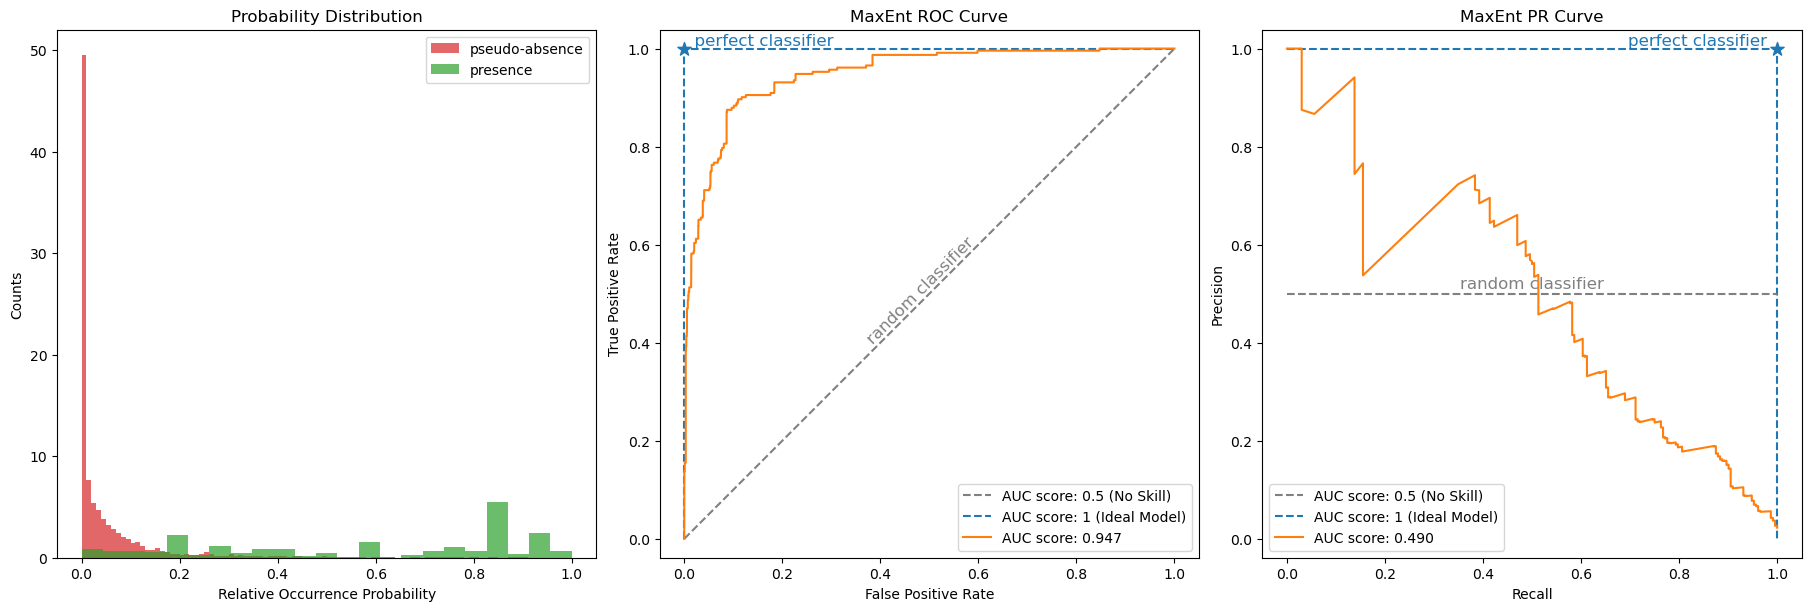

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6),constrained_layout=True)

# 
ax[0].hist(y_predict[y==0], bins=np.linspace(0,1,int((y==0).sum()/100 + 1)), density=True, color='tab:red', alpha=0.7, label='pseudo-absence')
ax[0].hist(y_predict[y==1], bins=np.linspace(0,1,int((y==1).sum()/10+1)), density=True, color='tab:green', alpha=0.7, label='presence')

ax[0].set_xlabel('Relative Occurrence Probability')
ax[0].set_ylabel('Counts')
ax[0].set_title('Probability Distribution')

ax[0].legend(loc='upper right')

ax[1].plot([0, 1], [0, 1], '--', label=f'AUC score: 0.5 (No Skill)', color='gray')
ax[1].text(0.4, 0.4, 'random classifier', fontsize=12, color='gray',
           rotation=45, rotation_mode='anchor', horizontalalignment='left',
           verticalalignment='bottom',transform=ax[1].transAxes)

ax[1].plot([0, 0, 1], [0, 1, 1], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[1].text(0, 1, '  perfect classifier', fontsize=12, color='tab:blue', 
           horizontalalignment='left', verticalalignment='bottom')
ax[1].scatter(0, 1, marker='*', s=100, color='tab:blue')

ax[1].plot(fpr, tpr, label=f'AUC score: {auc:0.3f}', color='tab:orange')
ax[1].axis('equal')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('MaxEnt ROC Curve')
ax[1].legend(loc='lower right')

## 
ax[2].plot([0, 1], [0.5, 0.5], '--', color='gray', label=f'AUC score: 0.5 (No Skill)')
ax[2].text(0.5, 0.52, 'random classifier', fontsize=12, color='gray',
           horizontalalignment='center', verticalalignment='center')
ax[2].plot([0, 1, 1], [1, 1, 0], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[2].text(1, 1, 'perfect classifier  ', fontsize=12, color='tab:blue', 
           horizontalalignment='right', verticalalignment='bottom')
ax[2].scatter(1, 1, marker='*', s=100, color='tab:blue')


ax[2].plot(recall, precision, label=f'AUC score: {pr_auc:0.3f}', color='tab:orange')
ax[2].axis('equal')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('MaxEnt PR Curve')
ax[2].legend(loc='lower left')


## 2. Predict model for region of interest

(!) continue here, use instead of x from training a xpred for area of interest

### 2.1 load test data

In [15]:
rasters, labels = (['srtm_%s.tif' %training], ['srtm']) if topo else ([], []) # 'ndvi_east-asia.tif', 'ndvi' # 
for no in bioclim:
    rasters.append('wc2.1_10m_bio-%02d_%s.tif' %(no, interest))
    labels.append('bioclim_%02d' %no)

raster_paths = [os.path.join(input_path, 'test', raster) for raster in rasters]

# initialise dataset for model output
test_output = xr.Dataset()
for raster, label in zip(raster_paths, labels):
    da = rioxr.open_rasterio(raster, masked=True)
    test_output[label] = da

In [16]:
presence_file_name = '%s_presence_%s.csv' %(specie, interest)
background_file_name = '%s_background_%s_%s.csv' %(specie, pseudoabsence, interest)
test_input_data_name = 'model-test_input-data_%s_%s_%s.csv' %(specie, pseudoabsence, training)

presence_csv = pd.read_csv(os.path.join(input_path, 'test', presence_file_name))
geometry = gpd.points_from_xy(presence_csv['lon'], presence_csv['lat'])
presence_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

background_csv = pd.read_csv(os.path.join(input_path, 'test', background_file_name))
geometry = gpd.points_from_xy(background_csv['lon'], background_csv['lat'])
background_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

In [17]:
if len(presence_gdf) == 0:
    print('There are no occurrences of this specie in this region!')
    # chose arbitrary coordinate to make the code run
    presence_gdf.geometry=gpd.points_from_xy([115], [0])

There are no occurrences of this specie in this region!


In [18]:
presence_test = ela.annotate(
    presence_gdf.geometry,
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

background_test = ela.annotate(
    background_gdf, #pseudoabsence_random, pseudoabsence_bias_eucalyptus, #pseudoabsence_bias_perc_planted
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

test = ela.stack_geodataframes(
    presence_test,
    background_test,
    add_class_label=True,
)

test.to_csv(os.path.join(exp_path, test_input_data_name))

Raster:   0%|                              | 0/4 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1 [00:00<?, ?it/s]

Raster:   0%|                              | 0/4 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

### 2.2 model predict for region of interest/ test data

In [19]:
nc_name = 'model-test_%s_%s_%s.nc' %(specie, pseudoabsence, training)
raster_name = 'model-test_%s_%s_%s.tif' %(specie, pseudoabsence, training)

In [21]:
# split the x/y data
x_test = test.drop(columns=['class', 'geometry'])
y_test = test['class']

# predict the model for the test data
y_test_predict = model_train.predict(x_test)

# save the environment variables and model predictions to xarray.Dataset
array = test_output.isel(band=0).to_array().values
nodata = np.nan
nodata_idx = np.isnan(array)
rop = ela.geo.apply_model_to_array(model_train, array, nodata, nodata_idx)

test_output['rop'] = (('band', 'y', 'x'), rop)
test_output['rop'].attrs['long_name'] = "relative occurrence probability"

# write model output to netcdf
test_output.to_netcdf(os.path.join(exp_path, nc_name))

# write model predictions to raster
ela.apply_model_to_rasters(model_train, raster_paths, os.path.join(exp_path, raster_name), quiet=True)

### 2.3 test data performance

In [22]:
# ROC-curve
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_predict)

# PR-curve
precision_test, recall_test, _= metrics.precision_recall_curve(y_test, y_test_predict) 
pr_auc_test = metrics.auc(recall_test, precision_test)

print(f"Training ROC-AUC score: {auc:0.3f}")
print(f"Test ROC-AUC score: {auc_test:0.3f}")

print(f"Training PR-AUC Score: {pr_auc:0.3f}")
print(f"Test PR-AUC Score: {pr_auc_test:0.3f}")

Training ROC-AUC score: 0.947
Test ROC-AUC score: 0.987
Training PR-AUC Score: 0.490
Test PR-AUC Score: 0.004


In [23]:
import matplotlib.colors as mcolors

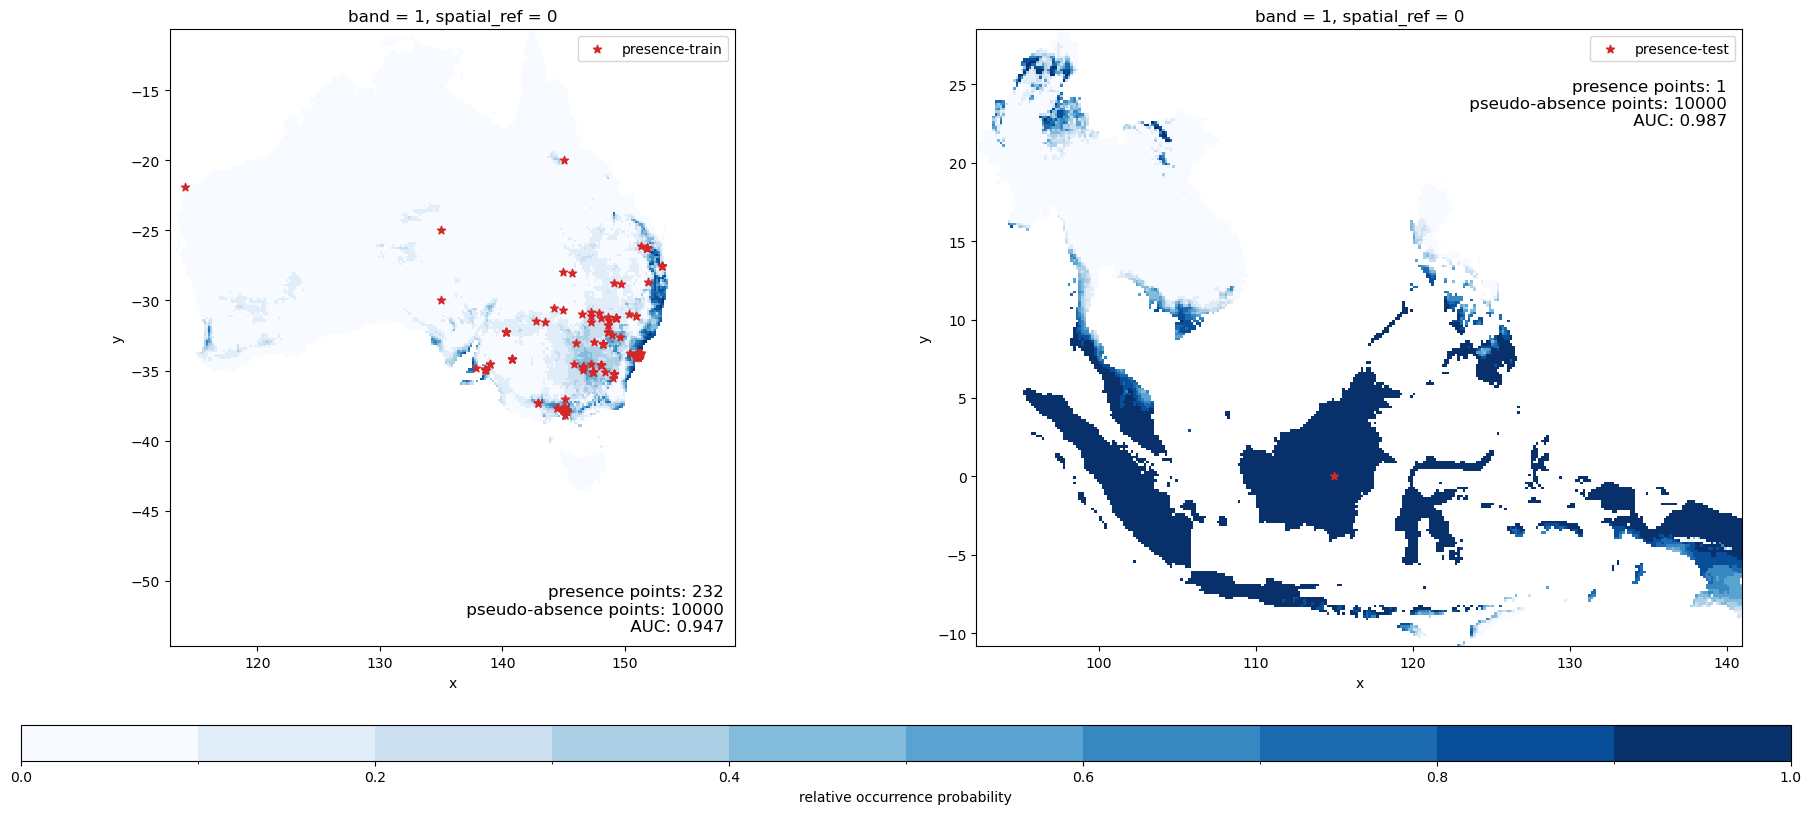

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True) #dpi=100

cmap = plt.cm.Blues #'GnBu'
bounds = np.linspace(0, 1, 11)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# pcol = train_out.plot(ax=ax[0], vmin=0, vmax=1, cmap='GnBu', add_colorbar=False)
pcol = training_output.rop.plot(ax=ax[0], vmin=0, vmax=1, norm=norm, cmap=cmap, add_colorbar=False)
presence_train.plot(ax=ax[0], color='tab:red', marker='*', label='presence-train')
ax[0].text(0.98, 0.02, 'presence points: %s\n pseudo-absence points: %s\n AUC: %.3f' %(len(presence_train), len(background_train), auc), fontsize=12, 
           horizontalalignment='right', verticalalignment='bottom', transform=ax[0].transAxes)
ax[0].legend()

pcol = test_output.rop.plot(ax=ax[1], vmin=0, vmax=1, norm=norm, cmap=cmap, add_colorbar=False)
presence_test.plot(ax=ax[1], color='tab:red', marker='*', label='presence-test')
ax[1].text(0.98, 0.92, 'presence points: %s\n pseudo-absence points: %s\n AUC: %.3f' %(len(presence_test), len(background_test), auc_test), fontsize=12, 
           horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)
ax[1].legend()

cbar = fig.colorbar(pcol, ax=ax, aspect=50, pad=0.05, label="relative occurrence probability", orientation='horizontal')

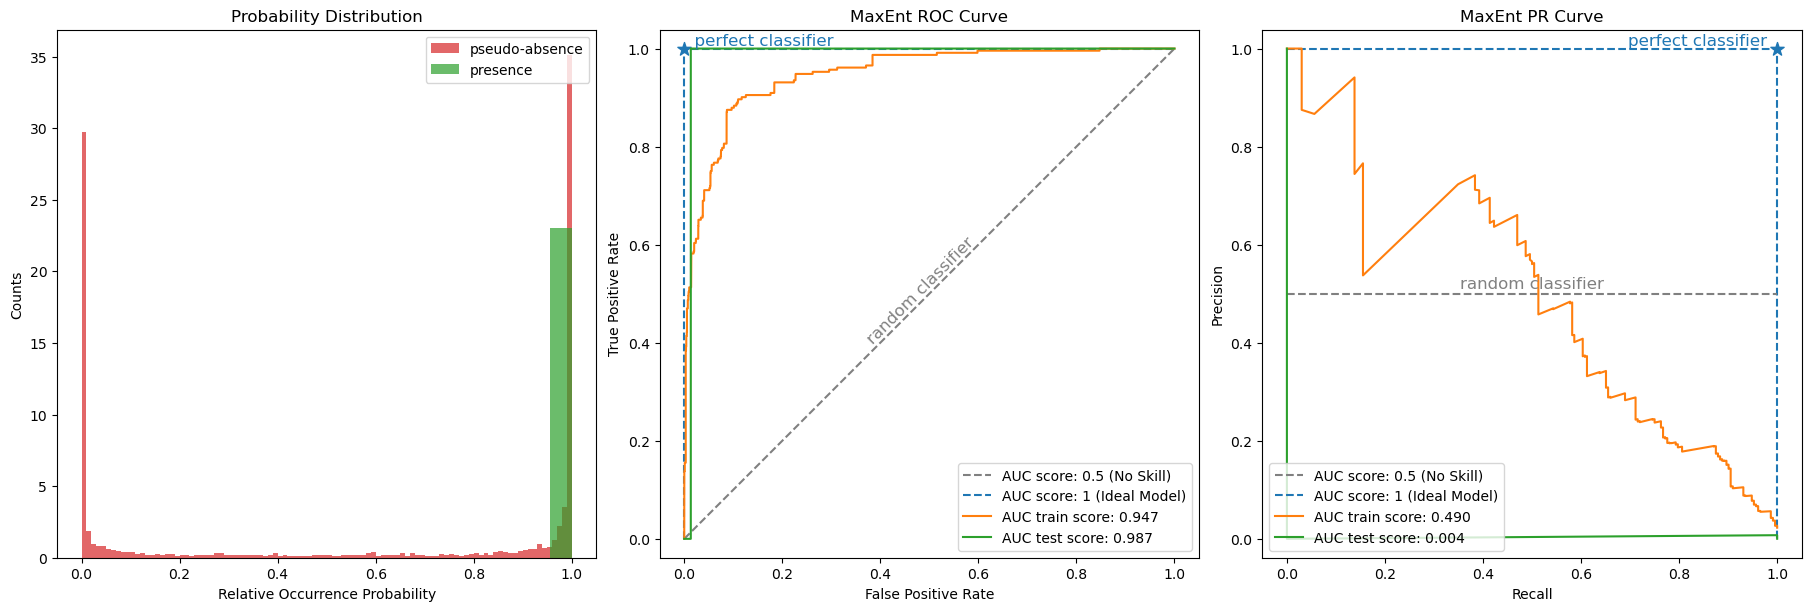

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6),constrained_layout=True)

# 
ax[0].hist(y_test_predict[y_test==0], bins=np.linspace(0,1,int((y==0).sum()/100 + 1)), density=True, color='tab:red', alpha=0.7, label='pseudo-absence')
ax[0].hist(y_test_predict[y_test==1], bins=np.linspace(0,1,int((y==1).sum()/10+1)), density=True, color='tab:green', alpha=0.7, label='presence')

ax[0].set_xlabel('Relative Occurrence Probability')
ax[0].set_ylabel('Counts')
ax[0].set_title('Probability Distribution')

ax[0].legend(loc='upper right')

ax[1].plot([0, 1], [0, 1], '--', label=f'AUC score: 0.5 (No Skill)', color='gray')
ax[1].text(0.4, 0.4, 'random classifier', fontsize=12, color='gray',
           rotation=45, rotation_mode='anchor', horizontalalignment='left',
           verticalalignment='bottom',transform=ax[1].transAxes)

ax[1].plot([0, 0, 1], [0, 1, 1], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[1].text(0, 1, '  perfect classifier', fontsize=12, color='tab:blue', 
           horizontalalignment='left', verticalalignment='bottom')
ax[1].scatter(0, 1, marker='*', s=100, color='tab:blue')

ax[1].plot(fpr, tpr, label=f'AUC train score: {auc:0.3f}', color='tab:orange')
ax[1].plot(fpr_test, tpr_test, label=f'AUC test score: {auc_test:0.3f}', color='tab:green')

ax[1].axis('equal')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('MaxEnt ROC Curve')
ax[1].legend(loc='lower right')

## 
ax[2].plot([0, 1], [0.5, 0.5], '--', color='gray', label=f'AUC score: 0.5 (No Skill)')
ax[2].text(0.5, 0.52, 'random classifier', fontsize=12, color='gray',
           horizontalalignment='center', verticalalignment='center')
ax[2].plot([0, 1, 1], [1, 1, 0], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[2].text(1, 1, 'perfect classifier  ', fontsize=12, color='tab:blue', 
           horizontalalignment='right', verticalalignment='bottom')
ax[2].scatter(1, 1, marker='*', s=100, color='tab:blue')


ax[2].plot(recall, precision, label=f'AUC train score: {pr_auc:0.3f}', color='tab:orange')
ax[2].plot(recall_test, precision_test, label=f'AUC test score: {pr_auc_test:0.3f}', color='tab:green')

ax[2].axis('equal')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('MaxEnt PR Curve')
ax[2].legend(loc='lower left')


In [26]:
# 3. Plot occurence probability for training ind interest regions

## 3. Evaluate model

### 3.1 Probability density plot

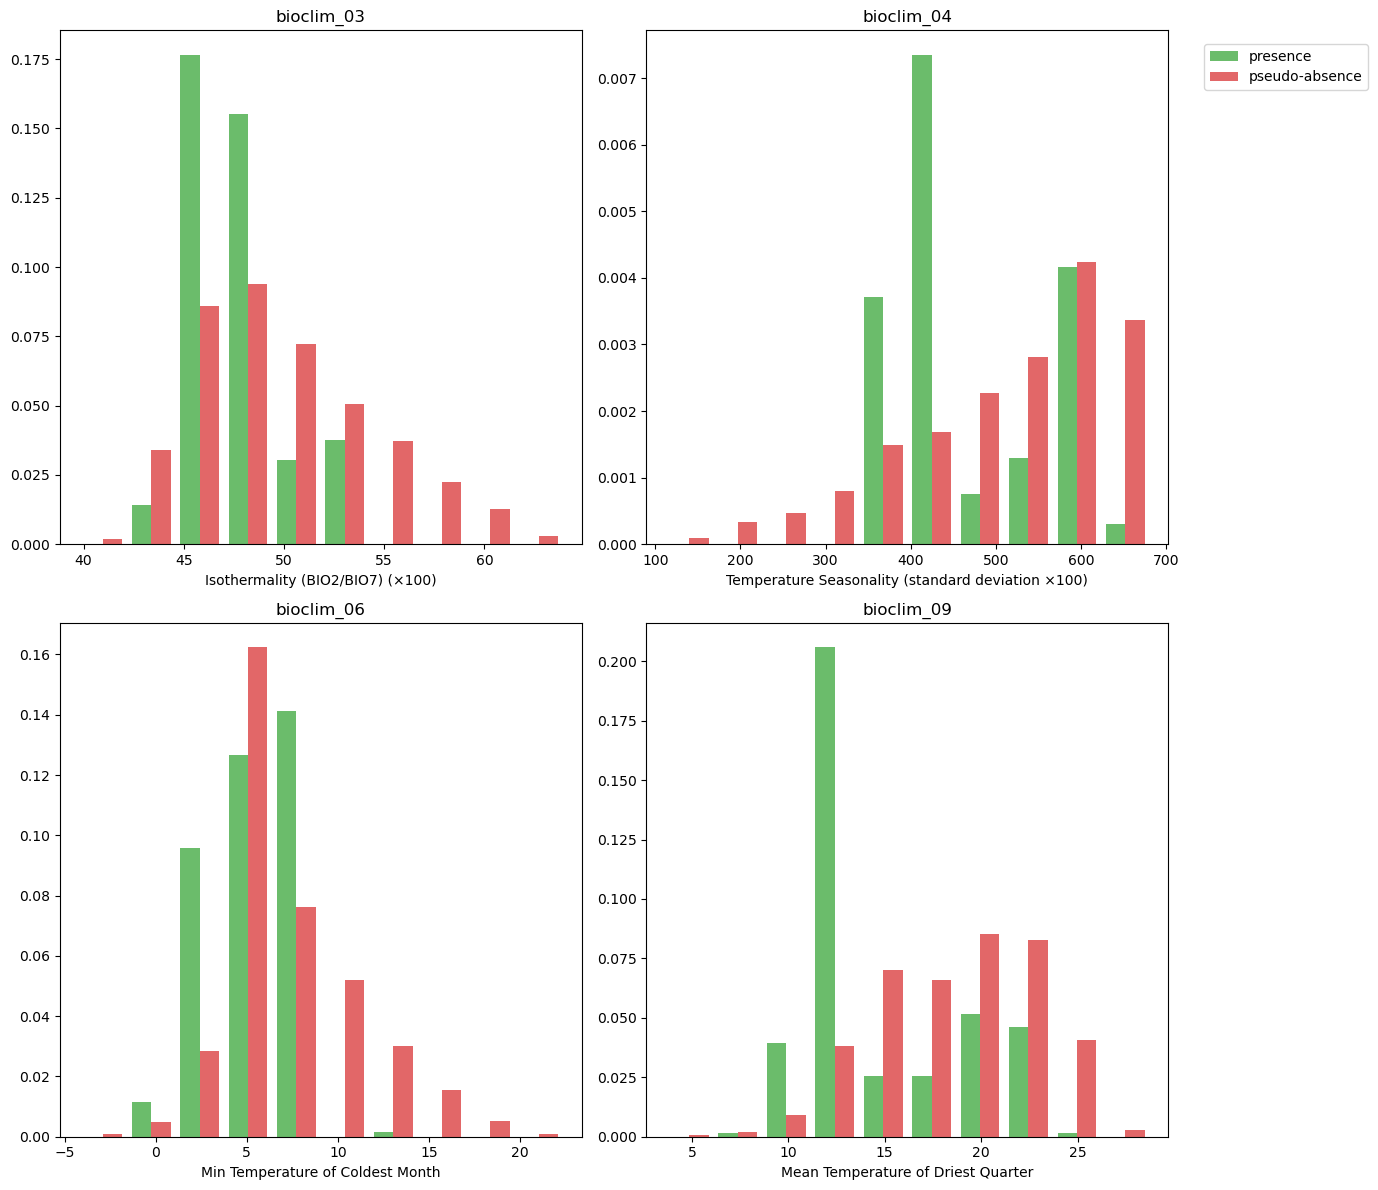

In [27]:
pair_colors = ['tab:green', 'tab:red']
ncols, nrows = subplot_layout(len(labels))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6,nrows*6))
if (nrows, ncols) == (1, 1):
    ax = [axs]
else:
    ax = axs.ravel()

xlabels = list(training_output.data_vars.keys())
for iax, label in enumerate(labels):
    pvar = presence_train[label]
    
    bvar = background_train[label]
    ax[iax].hist(
        [pvar, bvar],
        density=True,
        alpha=0.7,
        label=['presence', 'pseudo-absence'],
        color=pair_colors,
    )
    ax[iax].set_title(label)
    try:
        ax[iax].set_xlabel(training_output[xlabels[iax]].long_name)
    except AttributeError:
        ax[iax].set_xlabel('No variable long_name')
    
handles, lbls = ax[iax].get_legend_handles_labels()
fig.legend(handles, lbls, loc='upper right', bbox_to_anchor=(1.15, 0.965))
plt.tight_layout()

# # turn off empty plots
for axi in ax:
    if not axi.title.get_text():
        axi.set_visible(False)

### 3.2 Partial dependence plot/ Response curves

In [28]:
# fig, ax = model_train.partial_dependence_plot(x, labels=labels, dpi=100, n_bins=30)

In [29]:
percentiles = (0.025, 0.975)
nbins = 100

mean = np.zeros((len(labels), nbins))
stdv = np.zeros_like(mean)
bins = np.zeros_like(mean)

for idx in range(len(labels)):
    print(idx)

    pd = inspection.partial_dependence(
        model_train,
        x,
        [idx],
        percentiles=percentiles,
        grid_resolution=nbins,
        kind="individual",
    )
    mean[idx] = pd["individual"][0].mean(axis=0)
    stdv[idx] = pd["individual"][0].std(axis=0)
    bins[idx] = pd["values"][0]


0


/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


1


/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


2


/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


3


/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


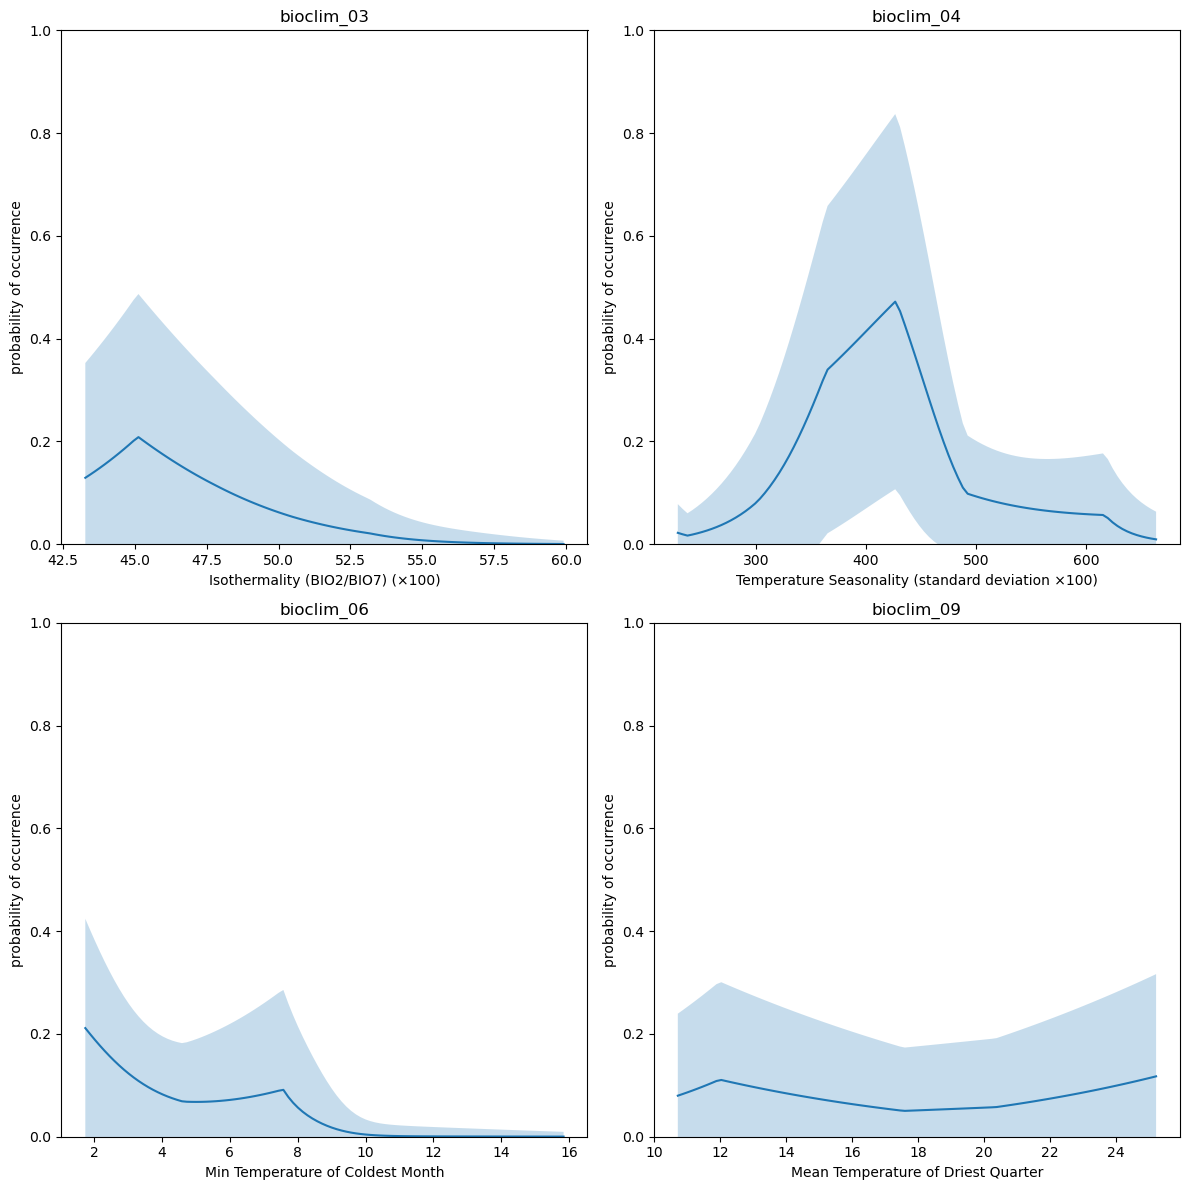

In [30]:
ncols, nrows = subplot_layout(len(labels))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6,nrows*6))

if (nrows, ncols) == (1, 1):
    ax = [axs]
else:
    ax = axs.ravel()

xlabels = list(training_output.data_vars.keys())
for iax, label in enumerate(labels):

    ax[iax].set_title(label)
    try:
        ax[iax].set_xlabel(training_output[xlabels[iax]].long_name)
    except AttributeError:
        ax[iax].set_xlabel('No variable long_name')

    ax[iax].fill_between(bins[iax], mean[iax] - stdv[iax], mean[iax] + stdv[iax], alpha=0.25)
    ax[iax].plot(bins[iax], mean[iax])
    ax[iax].set_title(label)

    
# turn off empty plots
for axi in ax:
    axi.set_ylim([0, 1])
    axi.set_ylabel('probability of occurrence')
#     if not axi.lines:
#         axi.set_visible(False)

fig.tight_layout()

### 3.3 Variable importance plot

In [31]:
# fig, ax = model_train.permutation_importance_plot(x,y)

In [32]:
pi = inspection.permutation_importance(model_train, x, y, n_repeats=10)
importance = pi.importances
rank_order = importance.mean(axis=-1).argsort()

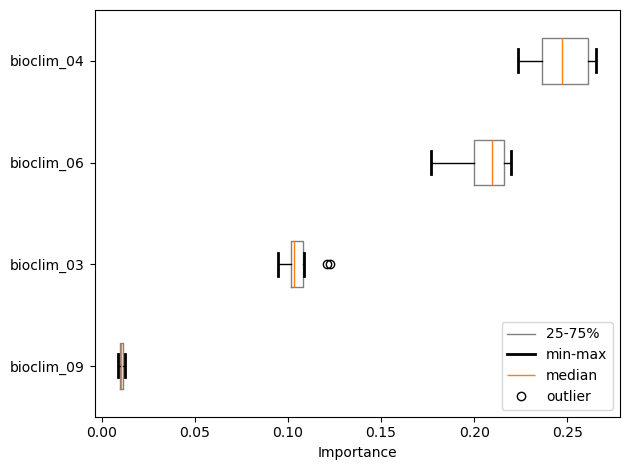

In [33]:
labels_ranked = [labels[idx] for idx in rank_order]

fig, ax = plt.subplots()
box = ax.boxplot(importance[rank_order].T, vert=False, labels=labels_ranked)
box['fliers'][0].set_label('outlier')
box['medians'][0].set_label('median')
for icap, cap in enumerate(box['caps']):
    if icap == 0:
        cap.set_label('min-max')
    cap.set_color('k')
    cap.set_linewidth(2)
for ibx, bx in enumerate(box['boxes']):
    if ibx == 0:
        bx.set_label('25-75%')
    bx.set_color('gray')

ax.set_xlabel('Importance')
ax.legend(loc='lower right')
fig.tight_layout()

In [ ]:
# train['split'] = 'train'
# test['split'] = 'test'
# merged = ela.stack_geodataframes(train, test)
# merged.to_csv(os.path.join(exp_path, input_data_name))

# xmerge = merged.drop(columns=['class', 'split'])
# ymerge = merged['class']

# merged.plot(column='split', markersize=0.1, legend=True)

In [19]:
# xtrain = train.drop(columns=['class', 'split'])
# ytrain = train['class']

# xtest = test.drop(columns=['class', 'split'])
# ytest = test['class']
# ytest = model_test.predict(train.iloc[np.where(train['class'] == 0)[0]])

# model_merge.fit(xtrain, ytrain)
# ypred_test = model_merge.predict(xtest)

# auc = metrics.roc_auc_score(ytest, ypred_test)
# print(f"Training AUC score: {auc:0.3f}")